## Lección 4. Modelos de Factores de Riesgo. 

### Objetivos Lección 4: 

1. Introducir el enfoque de factores de Riesgo para descomponer las primas de riesgo de un activo. Presentar los tres principales tipos de modelos: (1) Macroeconómicos (2) Fundamentales (3) Estadísticos.   


### Ejemplo de clase de Mercados completos.

In [1]:
# Importar las librerías: 
import pandas as pd
import numpy as np

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_8068\1997146918.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Esta función fue programada usando el complemento de copilot. 
def price_option(asset_prices, payments, Option):
    """
    Calculate the price of an option in a complete market.

    Parameters:
    asset_prices (pd.Series): A series representing the prices of the assets at t=0.
    payments (pd.DataFrame): A dataframe representing the payouts of the assets in each state of nature.
    Option (pd.Series): A series representing the payouts of the option we're trying to price.

    Returns:
    float: The price of the option.
    """
    # Calculate the number of units of each asset to hold to replicate the option
    units = np.linalg.solve(payments.values, Option.values)

    # Calculate the price of the option
    price = (units * asset_prices).sum()

    return units, price

In [3]:
# Parametros del ejemplo de clase. 
asset_prices = pd.Series([100, 1] , index = ['Asset 1', 'Asset 2'])
payments = pd.DataFrame([[75, 1.10],[125, 1.10]], columns = ['Asset 1', 'Asset 2'], index = ['State 1', 'State 2'])
option = pd.Series([0, 25], index = ['State 1', 'State 2'])

In [4]:
units, price = price_option(asset_prices, payments, option)
print(f"The price of the option is {units}")
print(f"The price of the option is {price}")

The price of the option is [  0.5        -34.09090909]
The price of the option is 15.909090909090914


### Ejemplo Factores de riesgo estadísticos

Utilizando los siguientes datos. Encuentre los componentes principales usando los valores propios de la matriz, SVD y MLT

| Nombre       | Descripción                                                                                        |
| ------------ | -------------------------------------------------------------------------------------------------- |
| Cash         | Índice de ICE Tresury Notes & Bills con vencimiento 0-3 meses                                      |
| TIPS         | Bonos del Tesoro de EE. UU. indexados a la inflación (TIPS), 1-5 años​                             |
| Corporativos | Bonos Corporativos con calificación crediticia AAA-A, 1-5 años​                                    |
| Emergentes   | Índice de ICE de Bonos Corporativos de Mercados Emergentes.                                        |
| MBS          | Índice de ICE de títulos respaldados por hipotecas emitidas por Agencias de EE. UU. (Agency MBS)​. |
| Equity       | Índice de retorno total del S&P500                                                                 |

In [5]:
# Cargar los datos del S&P 500.
import pandas as pd
from librerias.finance_operators import calculateLogReturns
from librerias.torsion import torsion

In [6]:
indices = pd.read_csv('Datos\\'+'Índices.csv', sep = ';')
indices

,ID,Cash,Tips,Corporativos,MBS,Equity,Emergentes
0,2006-01-31,104.630,101.7361,353.795,1267.487,1937.93,192.57
1,2006-02-01,104.643,101.5331,353.337,1265.328,1941.75,192.37
2,2006-02-02,104.655,101.4291,353.394,1265.584,1924.67,192.46
3,2006-02-03,104.671,101.5572,353.455,1266.487,1914.50,192.64
4,2006-02-06,104.707,101.5455,353.452,1266.868,1916.04,192.80
...,...,...,...,...,...,...,...
4581,2023-08-15,129.716,160.8998,582.801,2015.545,9549.17,405.38
4582,2023-08-16,129.735,160.6423,582.045,2011.529,9478.54,404.87
4583,2023-08-17,129.755,160.7714,582.219,2009.425,9407.27,403.71
4584,2023-08-18,129.811,160.9014,582.552,2014.660,9406.50,403.62


In [7]:
indices.index = pd.to_datetime(indices['ID'])
indices = indices.drop(columns=['ID'])

In [8]:
df_returns = calculateLogReturns(indices)
df_returns = df_returns.dropna() 
covariance_matrix = df_returns.cov()
minimum_torsion_matrix = torsion(covariance_matrix, df_returns, "minimum-torsion", method='exact', max_niter=100000)

In [9]:
# Aquí normalizamos los retornos antes de aplicarles el método de PCA.
df_returns = (df_returns - df_returns.mean())/len(df_returns) 

In [10]:
pca_matrix1_m1 = torsion(covariance_matrix, df_returns ,"PCA", method='exact', max_niter=10000, npcomp = 6)
pca_matrix1_m2 = torsion(covariance_matrix, df_returns ,"PCA-SVD", method='exact', max_niter=10000, npcomp = 6)

In [11]:
factor_index = ['Factor'+str(x) for x in range(1, len(df_returns.columns)+1)]
factor_loadings_mlt = pd.DataFrame(minimum_torsion_matrix, columns = covariance_matrix.columns, index =factor_index)
factor_loadings_mlt

,Cash,Tips,Corporativos,MBS,Equity,Emergentes
Factor1,1.000400,-0.001263,0.000340,0.000692,0.000189,0.000894
Factor2,-0.100370,1.170846,-0.319367,-0.143306,-0.002109,-0.093651
Factor3,0.021033,-0.248948,1.337090,-0.256783,0.011673,-0.197684
Factor4,0.096210,-0.250726,-0.576343,1.210565,0.002113,-0.059400
Factor5,0.754040,-0.105646,0.750192,0.060488,1.011917,-0.487969
Factor6,0.118438,-0.156080,-0.422654,-0.056583,-0.016234,1.129318


In [12]:
factor_loadings_pca_m1 = pd.DataFrame(pca_matrix1_m1, columns = covariance_matrix.columns, index = factor_index)
factor_loadings_pca_m2 = pd.DataFrame(pca_matrix1_m2, columns = covariance_matrix.columns, index = factor_index)


El algoritmo de Minimum Linear Torsion desarrollado por Romain Deguest et Al (2013) es un método para obtener factores estadísticos y poder desarrollar aplicaciones de Risk Budgesting o de optimización por Risk Parity. El método obtiene factores ortogonales que son mas intepretables que el modelo de PCA convencional. 

Text(0.5, 1.0, 'Factores de Carga Método MLT')

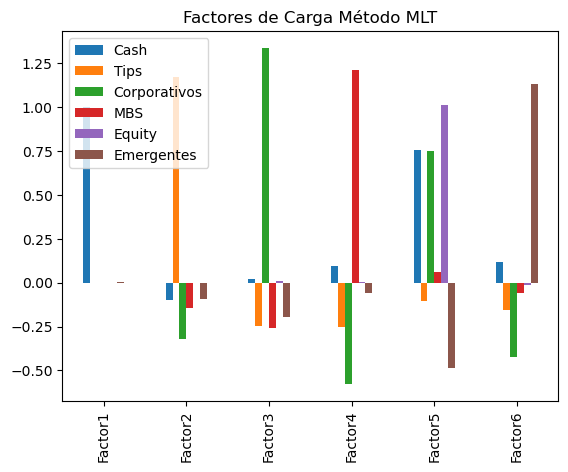

In [13]:
ax = factor_loadings_mlt.plot.bar()
ax.set_title('Factores de Carga Método MLT')

Text(0.5, 1.0, 'Factores de Carga Método PCA')

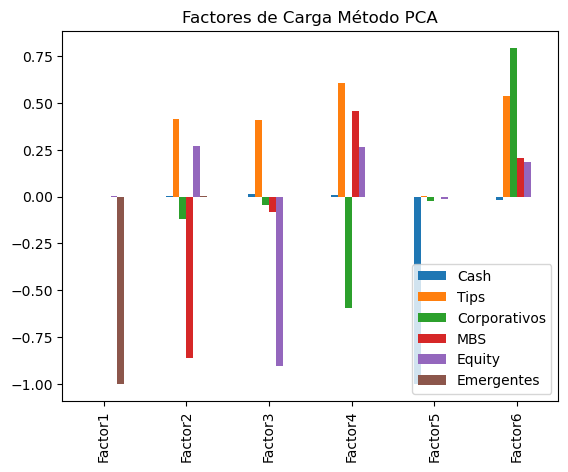

In [14]:
ax = factor_loadings_pca_m1.plot.bar()
ax.set_title('Factores de Carga Método PCA')

Text(0.5, 1.0, 'Factores de Carga Método SVD')

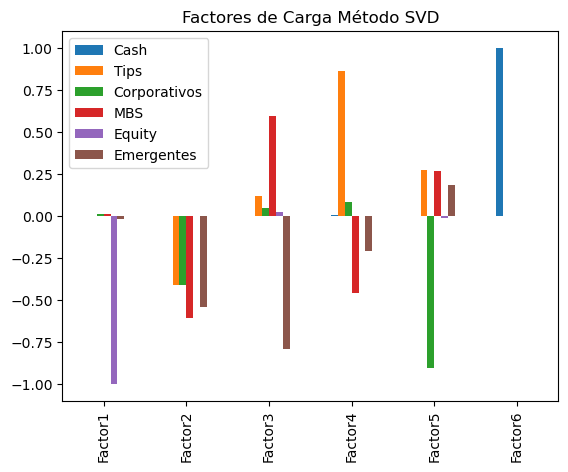

In [15]:
ax = factor_loadings_pca_m2.plot.bar()
ax.set_title('Factores de Carga Método SVD')

### Ejemplo 3: Obtención de Factores de Nivel, Pendiente y Curva con PCA.

Una de las principales aplicaciones de PCA Y de las poco donde guarda interpretabilidad es la de Componentes Principales aplicado a la curva de rendimientos. Al aplicarlo sobre los yields, crea los componentes de nivel, pendiente y curvatura. Antes de examinar la aplicación revisemos un poco algunas características de los datos:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from librerias.extract_data import get_data 
from librerias.graphs import *

#yield_df = get_data(start_year=2010,end_year=2023)
#yield_df = yield_df.sort_index()
# yield_df.to_csv('Datos\\'+'Yields_2010-2023.csv')

In [17]:
yield_df = pd.read_csv('Datos\\'+'Yields_2010-2023.csv')
yield_df.index = pd.to_datetime(yield_df.loc[:,'Date'])  
yield_df = yield_df.dropna()
yield_df = yield_df.iloc[:,1:]
yield_df

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,
2010-01-04,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,4.34,4.67,4.66,4.31,4.09,3.86,3.83,3.75,3.99,3.82
2022-12-27,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93
2022-12-28,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98


In [18]:
yield_df.corr() 
### Note que la correlación es mayor cuando el vencimiento de los títulos es similar.

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
3 Mo,1.000000,0.994131,0.978702,0.937747,0.886914,0.739279,0.573964,0.372704,0.159608,0.041155
6 Mo,0.994131,1.000000,0.993947,0.963417,0.917541,0.772179,0.604841,0.396808,0.180160,0.054328
1 Yr,0.978702,0.993947,1.000000,0.984645,0.947210,0.810104,0.643803,0.430585,0.207295,0.075824
2 Yr,0.937747,0.963417,0.984645,1.000000,0.986700,0.884565,0.734420,0.523103,0.292581,0.155754
3 Yr,0.886914,0.917541,0.947210,0.986700,1.000000,0.944759,0.822604,0.625782,0.398156,0.261280
5 Yr,0.739279,0.772179,0.810104,0.884565,0.944759,1.000000,0.961409,0.833804,0.646877,0.528497
7 Yr,0.573964,0.604841,0.643803,0.734420,0.822604,0.961409,1.000000,0.950814,0.823193,0.732256
10 Yr,0.372704,0.396808,0.430585,0.523103,0.625782,0.833804,0.950814,1.000000,0.954687,0.904602
20 Yr,0.159608,0.180160,0.207295,0.292581,0.398156,0.646877,0.823193,0.954687,1.000000,0.980049
30 Yr,0.041155,0.054328,0.075824,0.155754,0.261280,0.528497,0.732256,0.904602,0.980049,1.000000


In [19]:
yield_df.mean()

3 Mo     0.633739
6 Mo     0.727528
1 Yr     0.822801
2 Yr     1.017872
3 Yr     1.212196
5 Yr     1.605953
7 Yr     1.951605
10 Yr    2.255661
20 Yr    2.756839
30 Yr    2.969868
dtype: float64

Se puede notar que efectivamente hay cierta prima termino en promedio a lo largo del tiempo.

In [20]:
yield_df.diff().std()

3 Mo     0.023681
6 Mo     0.022393
1 Yr     0.026212
2 Yr     0.036707
3 Yr     0.042280
5 Yr     0.049533
7 Yr     0.052618
10 Yr    0.051707
20 Yr    0.052231
30 Yr    0.051584
dtype: float64

Se muestra que a mayor plazo mayor desviación estándar.

In [21]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
#Step1: We calculate the mean of the scaled data.
df_normalized_mean = pd.DataFrame(scale(yield_df))
#Step2: Remove any missing data points
df_normalized_mean.dropna(inplace=True)

Text(0.5, 1.0, 'Scree Plot')

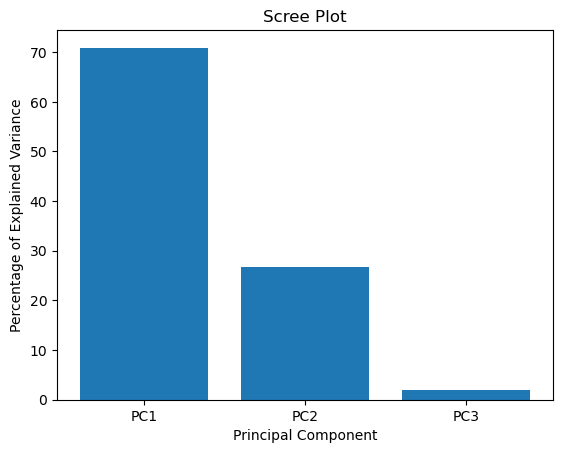

In [22]:

instruments = yield_df.columns
#Step3: We calculate the PCA using fit_transform
components = ['Level', 'Slope', 'Curve']
pca = PCA(n_components=len(components))

YC_PCA = pca.fit_transform(df_normalized_mean)
#Step4: Create a SCREE plot to check the weights of each component
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')


In [23]:
# Los eigenvalores de la matriz.

pca.explained_variance_

array([7.09539945, 2.66649767, 0.20288977])

El 70% de la variación en las tasas se explica por el factor de nivel, el 26.7% por el factor de pendiente, el 2% por el factor de curvatura.

Text(0.5, 1.0, 'Cumulative Explained Variance')

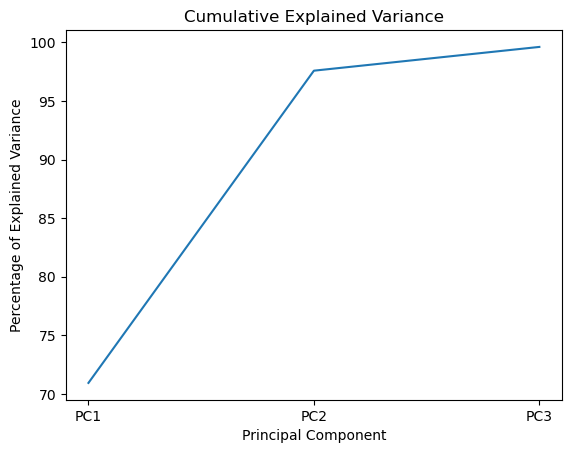

In [24]:
plt.plot(labels, pca.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Explained Variance')

In [25]:
# 
PC1, PC2, PC3 = pca.components_[0],pca.components_[1],pca.components_[2]
NumComponents = 3

topPorfolios = pd.DataFrame(pca.components_[:NumComponents],columns=instruments)
topPorfolios

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,0.315165,0.323955,0.332578,0.348506,0.360440,0.366666,0.346327,0.299477,0.232439,0.188790
1,-0.301796,-0.294470,-0.278497,-0.220085,-0.143287,0.052195,0.215065,0.368222,0.473333,0.516786
2,-0.472584,-0.341726,-0.164091,0.131361,0.326244,0.430281,0.330774,0.034096,-0.251852,-0.387461


(0.0, 0.14)

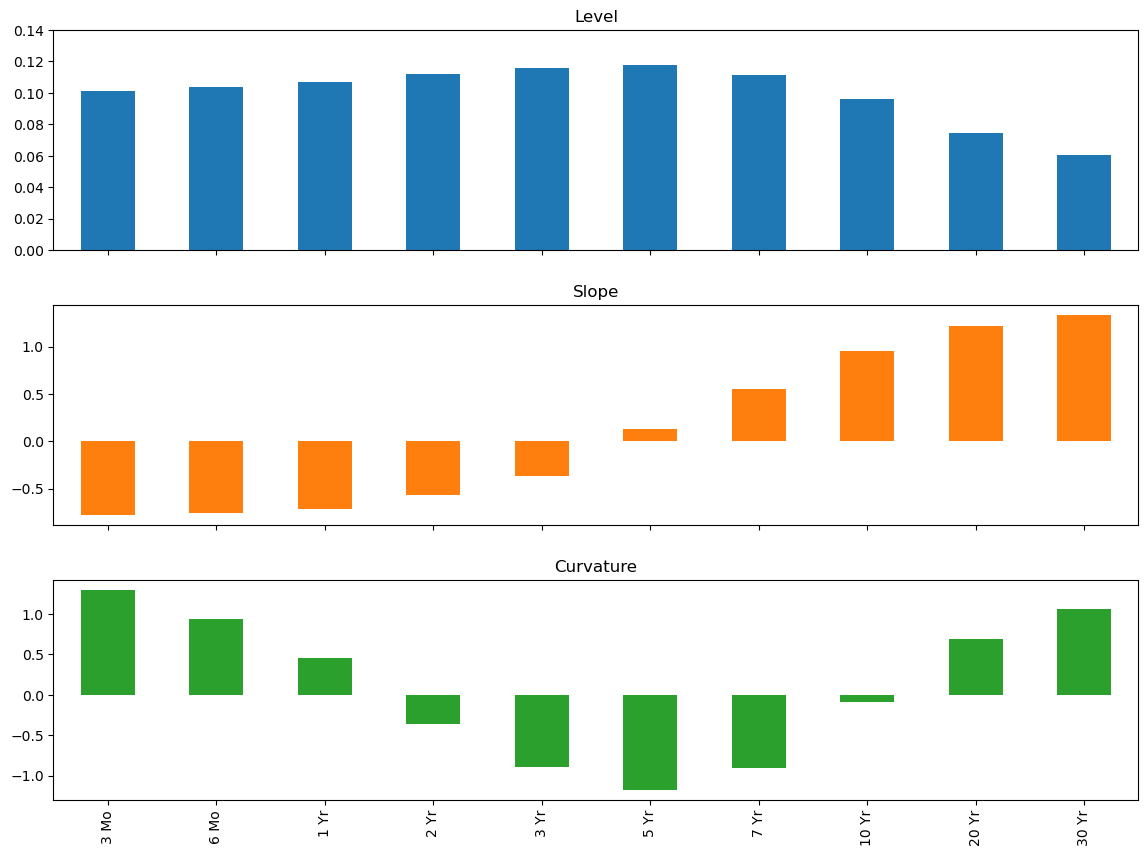

In [26]:

eigenPortfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
#eigenPortfolios.index = [ f'Portfolio {i}' for i in range(NumComponents)]
eigenPortfolios.index = ['Level', 'Slope', 'Curvature']
axs = eigenPortfolios.T.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.14)

In [27]:
# En el lenguaje de Data Science a estos Factores se les conoce como 'Scores' o PC Scores
orthogonal_factor = pd.DataFrame(YC_PCA, index = yield_df.index, columns = components)
orthogonal_factor 

,Level,Slope,Curve
Date,,,
2010-01-04,2.479370,3.888800,0.524148
2010-01-05,2.249886,3.792289,0.456785
2010-01-06,2.377425,3.985721,0.444246
2010-01-07,2.396440,3.966696,0.475048
2010-01-08,2.292577,3.985000,0.413060
...,...,...,...
2022-12-23,9.247949,-1.854960,-1.037102
2022-12-27,9.563351,-1.739185,-1.111409
2022-12-28,9.617610,-1.638873,-1.098185


<Axes: xlabel='Date'>

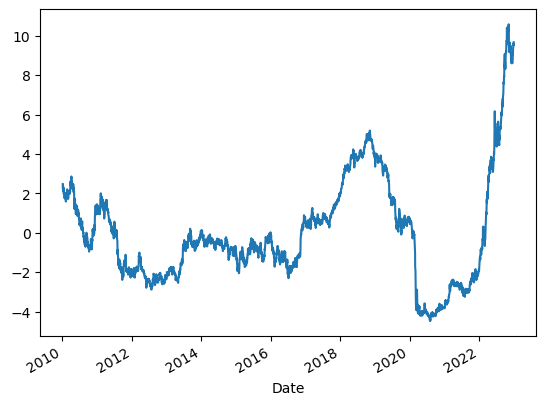

In [28]:
orthogonal_factor = orthogonal_factor.sort_index()
orthogonal_factor['Level'].plot()

<Axes: xlabel='Date'>

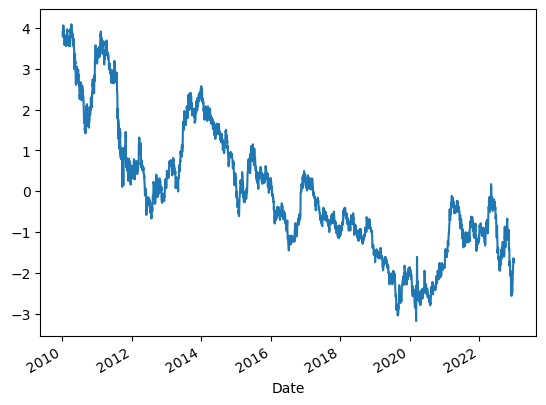

In [29]:
orthogonal_factor['Slope'].plot()

<Axes: xlabel='Date'>

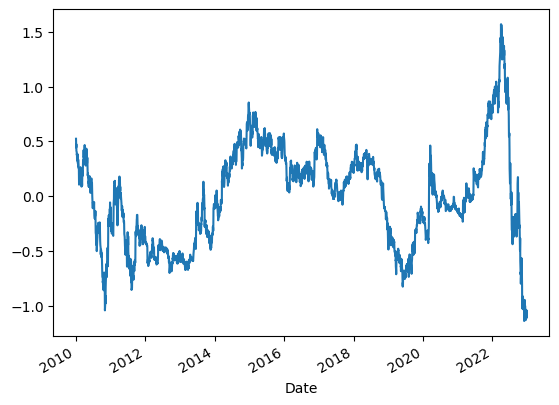

In [30]:
orthogonal_factor['Curve'].plot()

### Referencias 

EDHEC-Risk Institute (2019). Chapter 1.2 – Technical Supplement: Scientific. Lectures Notes for Advances in Asset Allocation Seminar 2020.

EDHEC-Risk Institute (2019). Chapter 1.3 – Technical Supplement: Scientific. Lectures Notes for Advances in Asset Allocation Seminar 2020.